# Hungry Geese
- You can play on Google
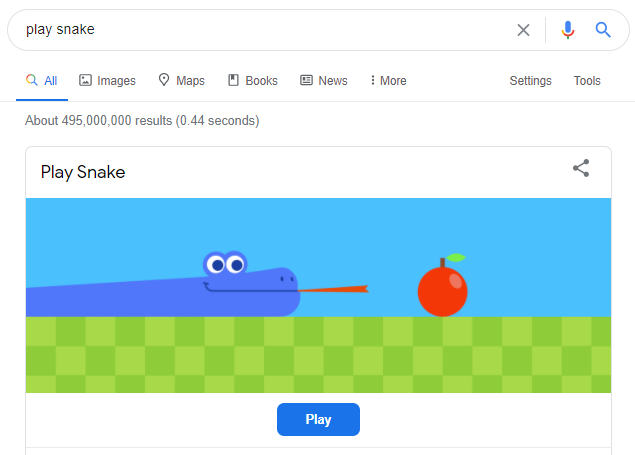

We will create an AI agent to play against others and survive the **longest** in this competition.

### How To Play
- Players will guide their goose throughout a 11 x 7 cell grid. You may instruct your goose to move `NORTH`, `SOUTH`, `EAST`, or `WEST`.
- The episode continues for 200 rounds - the agent with the highest reward, or the last agent remaining, wins the episode.
- The reward is calculated as the `current turn` + `goose length`.
- Agents can add a segment to their goose by eating food which appears on the board. Food can be donuts, pizza, pie, or peppers.
- There are a minimum of 2 food units on the board at all times. 
- Every 40 steps, the goose loses a segment.

### Important point
- That you have to be careful with the boundaries.
- There is no risk of being eaten if you follow the border, but others may eat the food first.

The baseline code was taken from the following reference:
https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/hungry_geese/hungry_geese.py

# baseline agent (just toward food)

In [ ]:
%%writefile base_agent.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col

def agent(obs_dict, config_dict):
    """This agent always moves toward observation.food[0] but does not take advantage of board wrapping"""
    observation = Observation(obs_dict)
    configuration = Configuration(config_dict)
    player_index = observation.index
    player_goose = observation.geese[player_index]
    player_head = player_goose[0]
    player_row, player_column = row_col(player_head, configuration.columns)
    food = observation.food[0]
    food_row, food_column = row_col(food, configuration.columns)

    if food_row > player_row:
        return Action.SOUTH.name
    if food_row < player_row:
        return Action.NORTH.name
    if food_column > player_column:
        return Action.EAST.name
    return Action.WEST.name

# baseline agent (greedy)

In [ ]:
%%writefile agent.py

from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col
from random import choice, sample

def random_agent():
    return choice([action for action in Action]).name


def translate(position: int, direction: Action, columns: int, rows: int):
    row, column = row_col(position, columns)
    row_offset, column_offset = direction.to_row_col()
    row = (row + row_offset) % rows
    column = (column + column_offset) % columns
    return row * columns + column


def adjacent_positions(position: int, columns: int, rows: int):
    return [
        translate(position, action, columns, rows)
        for action in Action
    ]


def min_distance(position: int, food: [int], columns: int):
    row, column = row_col(position, columns)
    return min(
        abs(row - food_row) + abs(column - food_column)
        for food_position in food
        for food_row, food_column in [row_col(food_position, columns)]
    )


def agent(observation, configuration):
    observation = Observation(observation)
    configuration = Configuration(configuration)
    rows, columns = configuration.rows, configuration.columns

    food = observation.food
    geese = observation.geese
    opponents = [
        goose
        for index, goose in enumerate(geese)
        if index != observation.index and len(goose) > 0
    ]

    # Don't move adjacent to any heads
    head_adjacent_positions = {
        opponent_head_adjacent
        for opponent in opponents
        for opponent_head in [opponent[0]]
        for opponent_head_adjacent in adjacent_positions(opponent_head, rows, columns)
    }
    # Don't move into any bodies
    bodies = {position for goose in geese for position in goose[0:-1]}
    # Don't move into tails of heads that are adjacent to food
    tails = {
        opponent[-1]
        for opponent in opponents
        for opponent_head in [opponent[0]]
        if any(
            adjacent_position in food
            # Head of opponent is adjacent to food so tail is not safe
            for adjacent_position in adjacent_positions(opponent_head, rows, columns)
        )
    }

    # Move to the closest food
    position = geese[observation.index][0]
    actions = {
        action: min_distance(new_position, food, columns)
        for action in Action
        for new_position in [translate(position, action, columns, rows)]
        if (
            new_position not in head_adjacent_positions and
            new_position not in bodies and
            new_position not in tails
        )
    }

    if any(actions):
        return min(actions, key=actions.get).name

    return random_agent()

# Render

In [ ]:
from kaggle_environments import *

In [ ]:
env = make("hungry_geese", configuration={"columns": 11, "rows": 7, "hunger_rate": 40, "min_food": 2 }, debug=True)

In [ ]:
output = env.run([agent, 'random'])

In [ ]:
# print('Left player: action = %s, reward = %s, status = %s, info = %s' % (output[0]["action"], output[0]['reward'], output[0]['status'], output[0]['info']))
# print('Right player: action = %s, reward = %s, status = %s, info = %s' % (output[1]["action"], output[1]['reward'], output[1]['status'], output[1]['info']))

In [ ]:
env.render(mode="ipython", width=800, height=600)